## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [7]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [9]:
from nndl import Softmax

In [13]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [14]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [15]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

## Answer:

Since we at first randomly initialized the weights, there are equally chance for each labels. As a result, the loss should around -ln(0.1) = 2.3

#### Softmax gradient

In [16]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.034928 analytic: 0.034928, relative error: 7.010383e-07
numerical: 0.267839 analytic: 0.267839, relative error: 5.129394e-08
numerical: 1.356864 analytic: 1.356864, relative error: 6.445159e-09
numerical: 1.164343 analytic: 1.164343, relative error: 6.391138e-09
numerical: 0.502163 analytic: 0.502163, relative error: 6.505720e-08
numerical: 2.159721 analytic: 2.159721, relative error: 7.414998e-09
numerical: -0.866250 analytic: -0.866250, relative error: 4.767461e-09
numerical: -1.211365 analytic: -1.211365, relative error: 5.249362e-09
numerical: 1.692624 analytic: 1.692624, relative error: 6.914043e-09
numerical: -2.459303 analytic: -2.459303, relative error: 2.386126e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [19]:
import time

In [25]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.339359231620361 / 355.62450083961147 computed in 0.24734115600585938s
Vectorized loss / grad: 2.339359231620361 / 355.62450083961147 computed in 0.0029969215393066406s
difference in loss / grad: 0.0 /3.271482755159673e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The gradient descent of softmax converage faster than SVM, so the training step of softmax should be much smaller than svm training step.

iteration 0 / 1500: loss 2.4102458120623145
iteration 100 / 1500: loss 2.0359077088826303
iteration 200 / 1500: loss 1.9806650706565916
iteration 300 / 1500: loss 1.9133638734243623
iteration 400 / 1500: loss 1.9152264045083047
iteration 500 / 1500: loss 1.8873816115811297
iteration 600 / 1500: loss 1.9320981631121084
iteration 700 / 1500: loss 1.8177800922461602
iteration 800 / 1500: loss 1.8861788961833807
iteration 900 / 1500: loss 1.8531254010910196
iteration 1000 / 1500: loss 1.8409744041207574
iteration 1100 / 1500: loss 1.823451685964941
iteration 1200 / 1500: loss 1.957318435830809
iteration 1300 / 1500: loss 1.7673885487691154
iteration 1400 / 1500: loss 1.8439562037405914
That took 9.625248432159424s


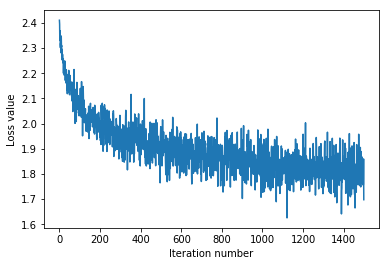

In [27]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [28]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.38004081632653064
validation accuracy: 0.386


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [29]:
np.finfo(float).eps

2.220446049250313e-16

In [39]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001,5e-6,1e-6,5e-7,1e-7,5e-8,
                 1e-8,5e-9,1e-9]
corrects = []
for learning_rate in learning_rates:
    loss_history = softmax.train(X_train,y_train,learning_rate)
    vali_pred = softmax.predict(X_val)
    correct = np.sum(vali_pred != y_val) / y_val.shape[0]
    corrects.append(correct)
    print("With learning rate of {0}, the validation loss is {1}".format(learning_rate,correct))
index = np.argmin(corrects)

print("\nAmong all the learning rates, the best learning rate is {}".format(learning_rates[index]))
print("The corresponding validation accuracy is {}".format(1-corrects[index]))

loss_history = softmax.train(X_train,y_train,learning_rates[index])
test_predict = softmax.predict(X_test)
error_rate = np.sum(test_predict != y_test) / y_test.shape[0]
print("With learning rate = {0}, the error rate on the test set is {1}".format(learning_rates[index] ,error_rate))


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


With learning rate of 0.01, the validation loss is 0.913
With learning rate of 0.005, the validation loss is 0.913
With learning rate of 0.001, the validation loss is 0.913
With learning rate of 0.0005, the validation loss is 0.913
With learning rate of 0.0001, the validation loss is 0.734
With learning rate of 5e-05, the validation loss is 0.767
With learning rate of 1e-05, the validation loss is 0.681
With learning rate of 5e-06, the validation loss is 0.642
With learning rate of 1e-06, the validation loss is 0.637
With learning rate of 5e-07, the validation loss is 0.643
With learning rate of 1e-07, the validation loss is 0.707
With learning rate of 5e-08, the validation loss is 0.781
With learning rate of 1e-08, the validation loss is 0.86
With learning rate of 5e-09, the validation loss is 0.886
With learning rate of 1e-09, the validation loss is 0.903

Among all the learning rates, the best learning rate is 1e-06
The corresponding validation accuracy is 0.363
With learning rate =